In [ ]:
!pip install scikeras

In [2]:
import keras
import joblib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from keras.layers import Input, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, LeakyReLU
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

import warnings
warnings.filterwarnings('ignore')

# Importing model and preparing Inputs

In [3]:
np.random.seed(1)
tf.random.set_seed(1)

num_classes = 6

In [ ]:
import urllib.request
import zipfile
# ZIP data URL from GitHub
zip_url = "https://github.com/NelloArchives/DL/raw/main/input_data.zip"
# Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)
# Unzip the folder
target_folder = "temp"
# reading data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)
data_path = f"{target_folder}/input_data.pkl"

In [4]:
target_folder = "temp"
data_path = f"{target_folder}/input_data.pkl"
#Then use the following lines to read it:
import pickle as pk
with open(data_path, 'rb') as f:
    dd = pk.load(f)

imgs = dd['imgs']
masks = dd['masks']

## Brief Analysis of the dataset

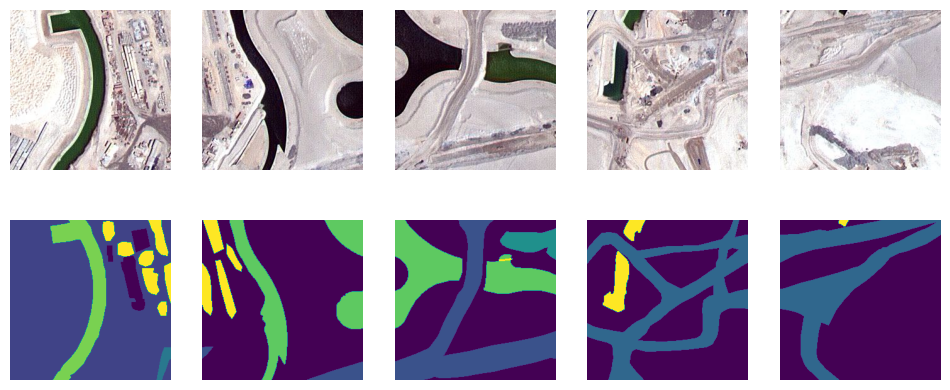

In [5]:
def plot_example(imgs, masks, num_images=5):
    plt.figure(figsize=(12, 5))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(imgs[i])
        plt.axis('off')
        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(masks[i])
        plt.axis('off')
    plt.show()

# Example usage
plot_example(imgs, masks, num_images=5)

In [6]:
print(imgs.shape, masks.shape)

(1305, 256, 256, 3) (1305, 256, 256, 1)


## Splitting The Data

In [7]:
imgs_train, imgs_test, masks_train, masks_test = train_test_split(
    imgs, masks, test_size=0.2, random_state=42
)

print("Training images shape:", imgs_train.shape)
print("Testing images shape:", imgs_test.shape)
print("Training masks shape:", masks_train.shape)
print("Testing masks shape:", masks_test.shape)

Training images shape: (1044, 256, 256, 3)
Testing images shape: (261, 256, 256, 3)
Training masks shape: (1044, 256, 256, 1)
Testing masks shape: (261, 256, 256, 1)


# Defining the model

The below is a wrapper to make it possible to use GridSearchCV from scikit-learn

the function ```build_model``` is structured as follow:
- preprocessing
- encoding with ```Conv2D``` and ```MaxPooling2d```
- decoding with ```Conv2DTranspose``` and ```Conv2d```, each time concatenation with corresponding encoding layer is done with ```concatenate```
- output layer shape=(256,256,6), activation = 'softmax'
- model compilation with loss = "sparse_categorical_crossentropy" and Adam optimizer

build_model can create models with different numbers on layers depending on the amount parameter passed

In [8]:
class KerasImageSegmentationModel(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 lr = 0.001,
                 filters = [8, 15, 21, 30],
                 filtersize = 3,
                 stride = 2,
                 epochs = 10,
                 batch_size = 8):

        self.lr = lr
        self.filters = filters
        self.filtersize = filtersize
        self.stride = stride
        self.epochs = epochs
        self.classes_ = np.arange(6)
        self.batch_size = batch_size
        self.model = self.build_model(lr, filters, filtersize, stride)

    def build_model(self, lr, filters, filtersize, stride):

        n_layers = len(filters)
        inputs = Input(shape = (256,256,3))

        s = Lambda(lambda x: x / 255) (inputs) # Preprocessing

        # Encoder
        conv_layers = []
        x = s
        for i in range(n_layers):
            x = Conv2D(filters[i], (filtersize, filtersize),  kernel_initializer='he_normal', padding='same')(x)
            x = LeakyReLU(negative_slope=0.1)(x)
            x = Conv2D(filters[i], (filtersize, filtersize), kernel_initializer='he_normal', padding='same')(x)
            x = LeakyReLU(negative_slope=0.1)(x)
            conv_layers.append(x)
            if i < n_layers - 1:
                x = MaxPooling2D((stride, stride))(x)

        # Decoder
        for i in range(n_layers - 2, -1, -1):
            x = Conv2DTranspose(filters[i], (stride, stride), strides=(stride,stride), padding='same')(x)
            x = concatenate([x, conv_layers[i]])
            x = Conv2D(filters[i], (filtersize, filtersize), kernel_initializer='he_normal', padding='same')(x)
            x = LeakyReLU(negative_slope=0.1)(x)
            x = Conv2D(filters[i], (filtersize, filtersize), kernel_initializer='he_normal', padding='same')(x)
            x = LeakyReLU(negative_slope=0.1)(x)

        x = Conv2D(1, filtersize, padding='same')(x)
        x = LeakyReLU(negative_slope=0.1)(x)
        outputs = Conv2D(6, 1, padding='valid', activation='softmax')(x)

        model = Model(inputs=[inputs], outputs=[outputs])
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"]
        )

        return model

    def fit(self, X, y, validation_data=None, callbacks=None):
        history = self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=2, validation_data=validation_data, callbacks=callbacks)
        return history

    def predict(self, X):
        return self.model.predict(X)

In [17]:
model = KerasImageSegmentationModel()
model.model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 256, 256,  │          0 │ input_layer_7[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_116 (Conv2D) │ (None, 256, 256,  │        224 │ lambda_7[0][0]    │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_109     │ (None, 256, 256,  │          0 │ conv2d_116[0][0]  │
│ (LeakyReLU)         │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_117 (Conv2D) │ (None, 256, 256,  │        584 │ leaky_re_lu_109[… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_110     │ (None, 256, 256,  │          0 │ conv2d_117[0][0]  │
│ (LeakyReLU)         │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 128, 128,  │          0 │ leaky_re_lu_110[… │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_118 (Conv2D) │ (None, 128, 128,  │      1,095 │ max_pooling2d_22… │
│                     │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_111     │ (None, 128, 128,  │          0 │ conv2d_118[0][0]  │
│ (LeakyReLU)         │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_119 (Conv2D) │ (None, 128, 128,  │      2,040 │ leaky_re_lu_111[… │
│                     │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_112     │ (None, 128, 128,  │          0 │ conv2d_119[0][0]  │
│ (LeakyReLU)         │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 64, 64,    │          0 │ leaky_re_lu_112[… │
│ (MaxPooling2D)      │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_120 (Conv2D) │ (None, 64, 64,    │      2,856 │ max_pooling2d_23… │
│                     │ 21)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_113     │ (None, 64, 64,    │          0 │ conv2d_120[0][0]  │
│ (LeakyReLU)         │ 21)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (Conv2D) │ (None, 64, 64,    │      3,990 │ leaky_re_lu_113[… │
│                     │ 21)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_114     │ (None, 64, 64,    │          0 │ conv2d_121[0][0]  │
│ (LeakyReLU)         │ 21)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 32, 32,    │          0 │ leaky_re_lu_114[

 Total params: 48,806 (190.65 KB)

 Trainable params: 48,806 (190.65 KB)

 Non-trainable params: 0 (0.00 B)

# HyperParameter Tuning

The below functions are custom functions to compute the equivalent of accuracy and f1 scores on image segmentation tasks:
- They both take the predicted masks and ground truth and flatten them going from (batch_size,256,256,1) -> (batch_size*256*256,1)
- then they compute the ```f1_score``` and ```accuracy_score``` on the two resulting vectors
- finally they are wrapped with ```make_scorer``` to be able to use them in ```GridSearchCV```

```accuracy_forImages``` is the equivalent of the mean pixel accuracy for each imgae
```f1_forImages``` will return on average lower scores since it treats each class equally due to average = "macro"

In [18]:
def f1_forImages(y_true, y_pred):

    y_pred = np.argmax(y_pred, axis=-1) #from probabilities to integers

    # Flatten the arrays to shape (batch_size * height * width,)
    y_true_flat = np.reshape(y_true, [-1])
    y_pred_flat = np.reshape(y_pred, [-1])

    f1 = f1_score(y_true_flat, y_pred_flat, average="macro") # to evaluate each class equally

    return f1


def accuracy_forImages(y_true, y_pred):

    y_pred = np.argmax(y_pred, axis=-1)

    y_true_flat = np.reshape(y_true, [-1])
    y_pred_flat = np.reshape(y_pred, [-1])

    acc = accuracy_score(y_true_flat, y_pred_flat)

    return acc

f1_scorer = make_scorer(f1_forImages, greater_is_better=True)
acc_scorer = make_scorer(accuracy_forImages, greater_is_better=True)

## GridSearchCV

In [9]:
model = KerasImageSegmentationModel()

#similar number of parameters is maintained across these configurations

filters = [[8, 12, 16, 20, 24], #51,061 parameters
           [8, 15, 21, 30]] # 48,806 parameters

filtersize = [5,7]
stride = [2] # due to RAM limitations I had to remove the hypertuning on stride, also, higher strides were hindering the model's performance
lr = [0.001, 0.0001]
batchsizes = [16, 32]

param_grid = {

    "filters": filters,
    "lr": lr,
    "filtersize": filtersize,
    "stride": stride,
    "batch_size": batchsizes
}

2024-07-19 13:46:09.945113: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-19 13:46:10.125176: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-19 13:46:10.125279: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-19 13:46:10.127450: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-19 13:46:10.127583: I external/local_xla/xla/stream_executor

In [ ]:
gs = GridSearchCV(estimator=model, param_grid=param_grid,
                  n_jobs=1,
                  scoring=f1_scorer,
                  error_score="raise",
                  cv=2,
                  verbose=3)


grid_result = gs.fit(imgs_train, masks_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
Epoch 1/10
33/33 - 33s - 1s/step - accuracy: 0.2810 - loss: 1.6110
Epoch 2/10
33/33 - 2s - 64ms/step - accuracy: 0.5738 - loss: 1.3476
Epoch 3/10
33/33 - 2s - 64ms/step - accuracy: 0.5755 - loss: 1.2421
Epoch 4/10
33/33 - 3s - 76ms/step - accuracy: 0.5807 - loss: 1.1803
Epoch 5/10
33/33 - 2s - 63ms/step - accuracy: 0.5844 - loss: 1.1364
Epoch 6/10
33/33 - 2s - 65ms/step - accuracy: 0.5885 - loss: 1.0997
Epoch 7/10
33/33 - 2s - 64ms/step - accuracy: 0.5982 - loss: 1.0704
Epoch 8/10
33/33 - 2s - 65ms/step - accuracy: 0.6061 - loss: 1.0270
Epoch 9/10
33/33 - 2s - 66ms/step - accuracy: 0.6133 - loss: 0.9857
Epoch 10/10
33/33 - 3s - 76ms/step - accuracy: 0.6282 - loss: 0.9585
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step
[CV 1/2] END batch_size=16, filters=[8, 12, 16, 20, 24], filtersize=5, lr=0.001, stride=2;, score=0.266 total time= 1.4min
Epoch 1/10
33/33 - 13s - 395ms/step - accuracy: 0.4951 - loss: 1.6779
Epoch 2/10
33/33 - 4s - 1

### Results of the GridSearchCV

In [12]:
print("Best: %f using %s" % (grid_result.best_score_,
                             grid_result.best_params_))

# means = grid_result.cv_results_['mean_test_score']
# params = grid_result.cv_results_['params']

best_params = gs.best_params_
# joblib_file = 'best_params.joblib'
# joblib.dump(best_params, joblib_file)
# results = grid_result.cv_results_
# joblib_file = "gsresults"
# joblib.dump(results, joblib_file)

Best: 0.303668 using {'batch_size': 16, 'filters': [8, 15, 21, 30], 'filtersize': 5, 'lr': 0.0001, 'stride': 2}


['best_params.joblib']

In [10]:
# gs_results = joblib.load("gsresults.joblib")
# best_params = joblib.load("best_params.joblib")

## EarlyStopping
Below I'm using early stopping to understand the number of epochs that my model needs until validation loss stops decreasing

In [46]:
imgs_train_new, imgs_val, masks_train_new, masks_val = train_test_split(
    imgs_train, masks_train, test_size=0.2, random_state=42
)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=15,
                               verbose=1,
                               restore_best_weights=True)


best_model = KerasImageSegmentationModel(**best_params, epochs= 250)
best_model.fit(imgs_train_new, masks_train_new, validation_data=(imgs_val, masks_val), callbacks=[early_stopping])

Epoch 1/250
53/53 - 13s - 241ms/step - accuracy: 0.1307 - loss: 1.7721 - val_accuracy: 0.1885 - val_loss: 1.7598
Epoch 2/250
53/53 - 4s - 75ms/step - accuracy: 0.1610 - loss: 1.7497 - val_accuracy: 0.1423 - val_loss: 1.7368
Epoch 3/250
53/53 - 4s - 76ms/step - accuracy: 0.1403 - loss: 1.7296 - val_accuracy: 0.1418 - val_loss: 1.7238
Epoch 4/250
53/53 - 4s - 76ms/step - accuracy: 0.1418 - loss: 1.7180 - val_accuracy: 0.1423 - val_loss: 1.7128
Epoch 5/250
53/53 - 4s - 75ms/step - accuracy: 0.1458 - loss: 1.7071 - val_accuracy: 0.1430 - val_loss: 1.7049
Epoch 6/250
53/53 - 4s - 75ms/step - accuracy: 0.1537 - loss: 1.6994 - val_accuracy: 0.1478 - val_loss: 1.6933
Epoch 7/250
53/53 - 4s - 76ms/step - accuracy: 0.1619 - loss: 1.6881 - val_accuracy: 0.1505 - val_loss: 1.6863
Epoch 8/250
53/53 - 4s - 76ms/step - accuracy: 0.1769 - loss: 1.6791 - val_accuracy: 0.1530 - val_loss: 1.6789
Epoch 9/250
53/53 - 4s - 76ms/step - accuracy: 0.1817 - loss: 1.6695 - val_accuracy: 0.1572 - val_loss: 1.6696

KerasImageSegmentationModel(batch_size=16, epochs=250, filtersize=5, lr=0.0001)

## Final Training
Best number of epochs seemed to be 180, I'll now train on both train and validation for 180 epochs.

I will also monitor the validation accuracy on the test data only to plot the learning curve later.

**No** tuning will be effected on the test data during this step.

In [121]:
tf.random.set_seed(26)

best_epochs = early_stopping.stopped_epoch
#best_epochs = 180
best_model = KerasImageSegmentationModel(**best_params, epochs= best_epochs)
history = best_model.fit(imgs_train, masks_train, validation_data=(imgs_test, masks_test))

Epoch 1/180
66/66 - 16s - 244ms/step - accuracy: 0.4761 - loss: 1.7935 - val_accuracy: 0.5363 - val_loss: 1.7173
Epoch 2/180
66/66 - 7s - 102ms/step - accuracy: 0.5320 - loss: 1.4783 - val_accuracy: 0.5364 - val_loss: 1.3439
Epoch 3/180
66/66 - 6s - 86ms/step - accuracy: 0.5325 - loss: 1.3130 - val_accuracy: 0.5399 - val_loss: 1.2209
Epoch 4/180
66/66 - 6s - 92ms/step - accuracy: 0.5397 - loss: 1.1996 - val_accuracy: 0.5417 - val_loss: 1.1829
Epoch 5/180
66/66 - 7s - 99ms/step - accuracy: 0.5386 - loss: 1.1715 - val_accuracy: 0.5385 - val_loss: 1.1509
Epoch 6/180
66/66 - 7s - 103ms/step - accuracy: 0.5389 - loss: 1.1481 - val_accuracy: 0.5406 - val_loss: 1.1139
Epoch 7/180
66/66 - 6s - 97ms/step - accuracy: 0.5395 - loss: 1.1319 - val_accuracy: 0.5419 - val_loss: 1.0911
Epoch 8/180
66/66 - 6s - 95ms/step - accuracy: 0.5395 - loss: 1.1153 - val_accuracy: 0.5421 - val_loss: 1.0747
Epoch 9/180
66/66 - 6s - 95ms/step - accuracy: 0.5374 - loss: 1.0982 - val_accuracy: 0.5405 - val_loss: 1.05

In [140]:
#best_model.save("best_model.h5")

In [19]:
#best_model = load_model('best_model.h5')

# Model Evaluation

In [20]:
train_preds = best_model.predict(imgs_train)
test_preds = best_model.predict(imgs_test)

2024-07-19 13:53:51.227979: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe604002b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-19 13:53:51.228035: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-07-19 13:53:51.275408: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-19 13:53:51.362650: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-07-19 13:53:51.643135: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 5/33 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step

I0000 00:00:1721390042.508180  140769 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 281ms/step


2024-07-19 13:54:11.538337: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1642070016 exceeds 10% of free system memory.


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 554ms/step


2024-07-19 13:54:19.280135: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 410517504 exceeds 10% of free system memory.


## Looking at some Prediction

Given the resource limitations the model could predict some of the mask almost correctly

However, sometimes the prediction are completely off

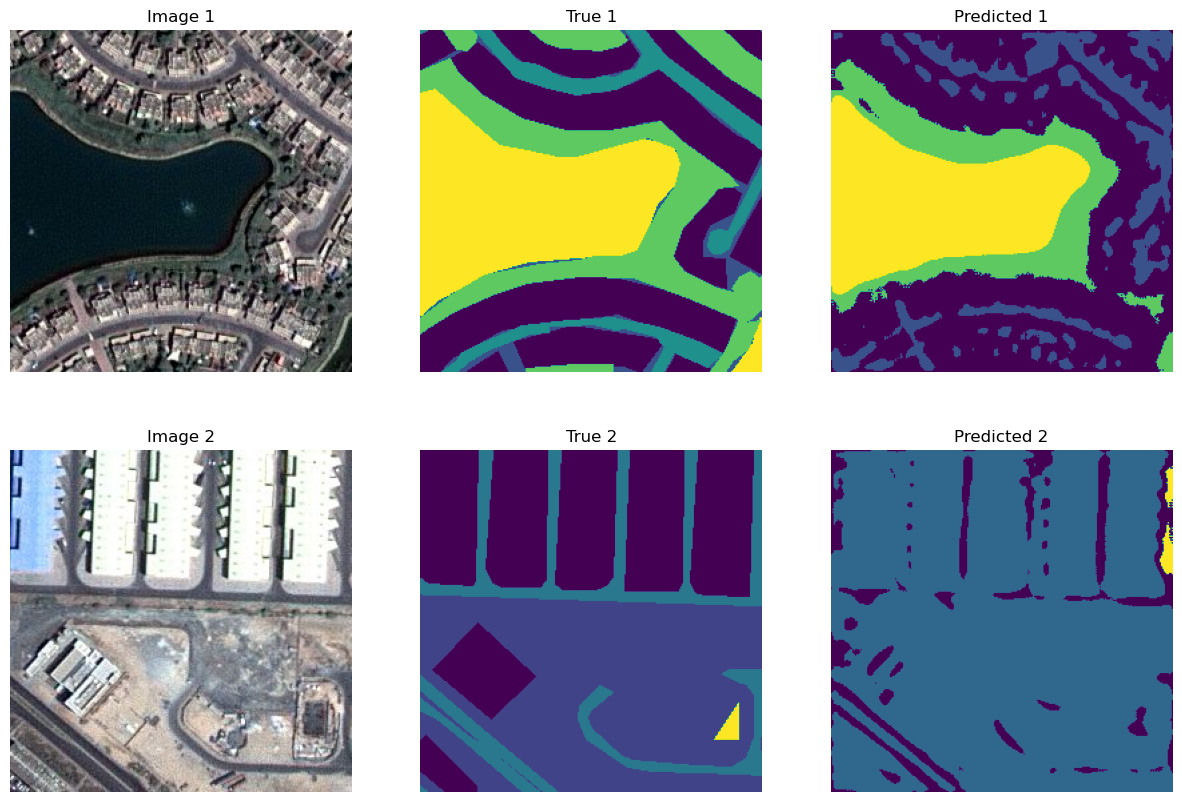

In [21]:
th_pred = np.argmax(test_preds, axis=-1)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))


i1 = 204
i2 = 214

axes[0, 0].imshow(imgs_test[i1])
axes[0, 0].set_title("Image 1")
axes[0, 0].axis('off')

axes[0, 1].imshow(masks_test[i1])
axes[0, 1].set_title("True 1")
axes[0, 1].axis('off')

axes[0, 2].imshow(th_pred[i1])
axes[0, 2].set_title("Predicted 1")
axes[0, 2].axis('off')

axes[1, 0].imshow(imgs_test[i2])
axes[1, 0].set_title("Image 2")
axes[1, 0].axis('off')

axes[1, 1].imshow(masks_test[i2])
axes[1, 1].set_title("True 2")
axes[1, 1].axis('off')

axes[1, 2].imshow(th_pred[i2])
axes[1, 2].set_title("Predicted 2")
axes[1, 2].axis('off')

plt.show()


## Scores on test and train data

I initially guessed that applying dropout and L2 regularization might hinder the learning of critical patterns because of the task's complexity.

Therefore, I decided not to apply them and the model showed no signs of overfitting.

It also seems that the test scores are a little higher than train ones, this could be due to random variability.

In [22]:
print("Test Set Results")
print(f"f1_score: {f1_forImages(masks_test,test_preds)}")
print(f"accuracy score: {accuracy_forImages(masks_test,test_preds)}")

print("Train Set Results")
print(f"f1_score: {f1_forImages(masks_train,train_preds)}")
print(f"accuracy score: {accuracy_forImages(masks_train,train_preds)}")

Test Set Results
f1_score: 0.49116027740010154
accuracy score: 0.7605474479353748
Train Set Results
f1_score: 0.4898544824851769
accuracy score: 0.7468500100789855


## Learning Curve

The learning curves suggest that the model can still learn more, as indicated by the ongoing improvements in accuracy and reductions in loss beyond the initial epochs.

Also, the curves suggest that a more complex model could be beneficial, as the current model is still learning without overfitting.

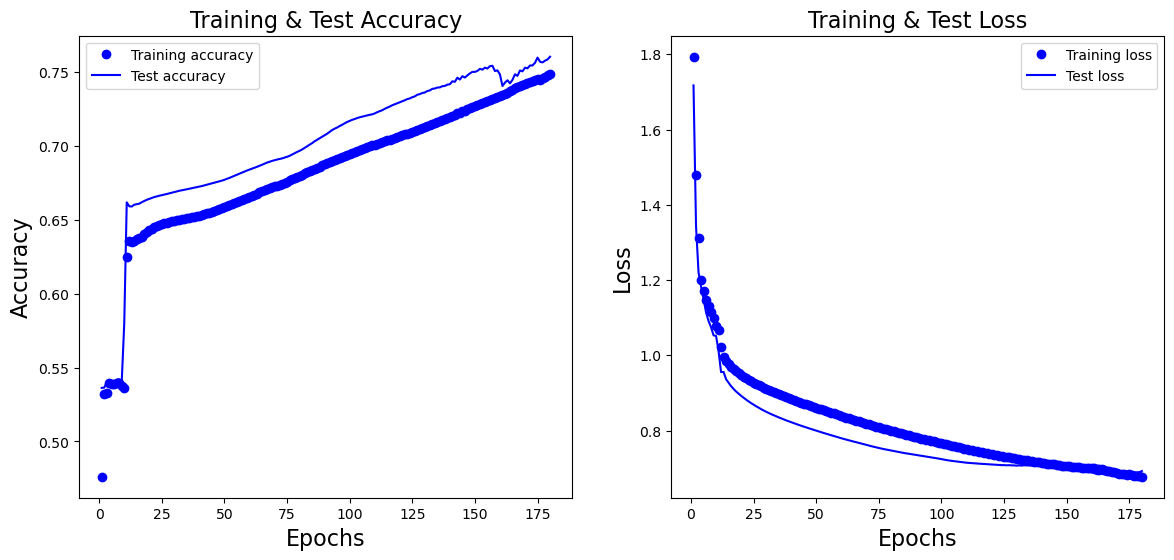

In [131]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Test accuracy')
ax[0].set_title('Training & Test Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Test loss')
ax[1].set_title('Training & Test Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()